## About The Neural Network

The network architecture used for our project is the DenseNet model. We are utilizing this architecture because in one of the papers, [The research on fingerprint recognition algorithm fused with deep learning](https://ieeexplore.ieee.org/document/9277456), researchers used the same architecture for their own neural network. According to the paper, the network was chosen due to its efficiency caused by each layer being closely related to other layers, allowing each layer to learn fewer features and therefore reduce redundancy. 

In [2]:
import tensorflow as tf
from tensorflow import data
from tensorflow import keras
from keras import layers
from keras.datasets import cifar10


import keras_tuner as kt

import matplotlib.pyplot as plt
import numpy as np
import torch
import time

import tensorflow_addons as tfa

We split the data into train/test/validation sets. Right now we are using a small dataset, where there are 4 classes, each relating to a person. We are using one finger to identify each person (right now the left index). There are 10 different scans of each finger. We apply a Gaussian Blur to the data to make it more readable for the NN.


Found 30 files belonging to 10 classes.
Found 57 files belonging to 10 classes.
Found 10 files belonging to 10 classes.


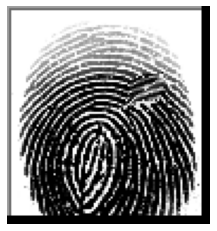

In [36]:
DATASET_SIZE = 120

train_directory = "./gen/train"
test_directory = "./gen/test"
valid_directory = "./gen/valid"

val_data = keras.utils.image_dataset_from_directory(
    valid_directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=8,
    image_size=(103, 96),
    shuffle=True,
    seed=7,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

train_data = keras.utils.image_dataset_from_directory(
    train_directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=8,
    image_size=(103, 96),
    shuffle=True,
    seed=7,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

test_data = keras.utils.image_dataset_from_directory(
    test_directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=4,
    image_size=(103, 96),
    shuffle=False,
    seed=7,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

for images, labels in train_data.take(1):
  for i in range (1):
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

# APPLYING GAUSSIAN BLUR TO ALL DATA
train_data = train_data.map(lambda x, y: (tfa.image.gaussian_filter2d(x), y))
val_data = val_data.map(lambda x, y: (tfa.image.gaussian_filter2d(x), y))
test_data = test_data.map(lambda x, y: (tfa.image.gaussian_filter2d(x), y))

# PREFETCH FOR PERFORMANCE
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

Because we are using such a small dataset for this checkpoint, we have to augment the data so the model doesn't just "memorize" the training data. Therefore, we apply a small random translation, rotation, and crop to every batch of images during training. Training, validation, and testing data are all cropped to 90x90 and normalized on input.

In [37]:
# Adding data augmentation for more accurate training and results
translation_layer = tf.keras.layers.RandomTranslation(0.1, 0.1)
normalization_layer = tf.keras.layers.Rescaling(1./255)
random_crop = tf.keras.layers.RandomCrop(90, 90)
rotation_layer = tf.keras.layers.RandomRotation(0.1)

test_model = keras.applications.DenseNet121(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(90, 90, 3),
    pooling='max',
    classes=10,
    classifier_activation="softmax"
)

preprocess_model = keras.Sequential()
preprocess_model.add(normalization_layer)
preprocess_model.add(random_crop)
preprocess_model.add(translation_layer)
preprocess_model.add(rotation_layer)
preprocess_model.add(test_model)

# Compile the model
preprocess_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Reduce learning rate on plateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4,
                              patience=5, min_lr=0)

# Train the model
preprocess_model.fit(train_data, validation_data=valid_data, epochs=100, callbacks=[reduce_lr])

# Evalutate the model
preprocess_model.evaluate(test_data)

Epoch 1/100


2022-12-05 14:49:38.098254: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: sequential_5/random_crop_5/loop_body/cond/pfor/cond/branch_executed/_192


8/8 [==============================] - 13s 323ms/step - loss: 2.1053 - accuracy: 0.2807 - val_loss: 2.3216 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 2s 194ms/step - loss: 1.6583 - accuracy: 0.4211 - val_loss: 2.3169 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 1s 184ms/step - loss: 0.7408 - accuracy: 0.7544 - val_loss: 2.3418 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 1s 179ms/step - loss: 0.6360 - accuracy: 0.7719 - val_loss: 2.4025 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 1s 180ms/step - loss: 0.3729 - accuracy: 0.8596 - val_loss: 2.4642 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 2s 183ms/step - loss: 0.3428 - accuracy: 0.8947 - val_loss: 2.8016 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 7/100
8/8 [==============================] - 1s 185ms/step - loss: 0.6229 - a

[0.004958357661962509, 1.0]

3/3 [==============================] - 0s 27ms/step


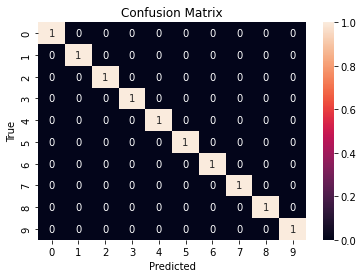

3/3 [==============================] - 0s 31ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



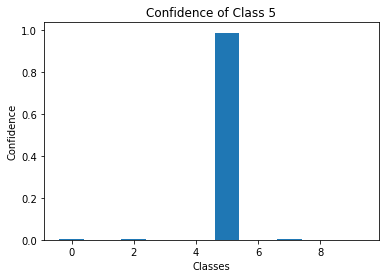

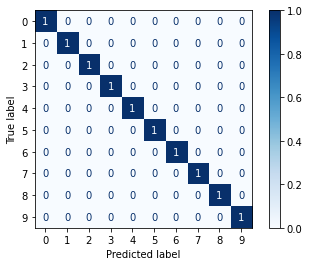

In [66]:
# Print a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = preprocess_model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)

y_true = []
for images, labels in test_data:
  y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d")

# Label the confusion matrix

plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix')
plt.show()

# Create a bar graph of the accuracy of each class

potentialLabels = []
for i in range(10):
  potentialLabels.append(i)
plt.bar(potentialLabels, preprocess_model.predict(test_data)[5])
plt.xlabel('Classes')
plt.ylabel('Confidence')
plt.title('Confidence of Class 5')

# Make a continuous confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred = preprocess_model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)

y_true = []
for images, labels in test_data:
  y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=potentialLabels)
disp.plot(cmap=plt.cm.Blues)

# Print the accuracy of each class

from sklearn.metrics import classification_report

y_pred = preprocess_model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)

y_true = []
for images, labels in test_data:
  y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred))




